In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

<b>Campos da Base de Dados</b><br>
<b>idade</b> - idade do cliente em anos<br>
<b>experiencia</b> - tempo de experiência em anos<br>
<b>tempo_endereco</b> - tempo que mora no mesmo endereço em anos<br>
<b>renda</b> - renda anual em salários mínimos<br>
<b>debito_renda</b> - relação entre seus débitos (dívidas totais) e a renda anual<br>
<b>cred_deb</b> - razão entre seus créditos e débitos<br>
<b>outros_debitos</b> - Valor de outros débitos (em 1.000 reais)<br>
<b>mau</b> - se pagou o não o empréstimo bancário (0=pagou, 1=não pagou)<br>


In [2]:
df = pd.read_csv('base.csv', sep=';', decimal=',')

In [3]:
df.head()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,mau
0,41,17,12,35.9,11.90,0.504108,3.767992,0
1,30,13,8,46.7,17.88,1.352694,6.997266,0
2,40,15,14,61.8,10.64,3.438997,3.136523,0
3,41,15,14,72.0,29.67,4.165668,17.196732,0
4,57,7,37,25.6,15.86,1.498199,2.561961,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   idade           5000 non-null   int64  
 1   experiencia     5000 non-null   int64  
 2   tempo_endereco  5000 non-null   int64  
 3   renda           5000 non-null   float64
 4   debito_renda    5000 non-null   float64
 5   cred_deb        5000 non-null   float64
 6   outros_debitos  5000 non-null   float64
 7   mau             5000 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 312.6 KB


In [5]:
df.shape

(5000, 8)

In [6]:
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

idade             0
experiencia       0
tempo_endereco    0
renda             0
debito_renda      0
cred_deb          0
outros_debitos    0
mau               0
dtype: int64

In [8]:
df.describe()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,mau
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,35.387200,8.703800,8.154000,47.676980,10.075984,1.628071,3.218582,0.251200
std,7.948403,7.194583,6.760786,51.793192,6.659336,3.053369,6.944523,0.433747
min,20.000000,0.000000,0.000000,12.100000,0.080000,0.005292,0.009373,0.000000
25%,29.000000,3.000000,3.000000,24.500000,5.050000,0.396181,0.990071,0.000000
50%,35.000000,7.000000,7.000000,34.500000,8.635000,0.906189,1.960223,0.000000
75%,41.000000,13.000000,12.000000,54.725000,13.682500,1.859147,3.789633,1.000000
max,58.000000,38.000000,37.000000,2461.700000,44.620000,139.580605,416.517425,1.000000


Vericada a estrutura dos dados, a base tem 5.000 registros com 8 colunas, todas são numéricas. Não existem registros repetidos na base, também não existem registros faltantes.

Observa-se nas estatísticas descritivas que a idade média dos clientes é de 35,3 anos.<br>
Os valores das colunas experiencia e tempo_endereco são muito próximos, o valor mínimo de renda é 12 salarios anuais o que significa um salário mínimo por mês. <br>
No campo renda é possível ver que 75% dos clientes ganham até 54.7 salarios anuais e o valor máximo é de 2461,7 salários.

In [9]:
df.mau.value_counts() / df.mau.value_counts().sum()

0    0.7488
1    0.2512
Name: mau, dtype: float64

In [10]:
df.mau.value_counts()

0    3744
1    1256
Name: mau, dtype: int64

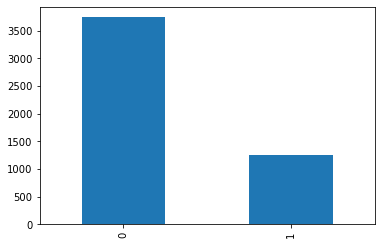

In [11]:
df.mau.value_counts().plot.bar()

### As classes estão desbalanceadas, 1.256 registros da base é composta por maus. Estes representam 25,12% da base.

<br><br>
## Análise das Variáveis<br>
As variáveis serão categorizadas com a função KBinsDiscretizer, será verificada a quantidade de itens em cada faixa para que tenha no mínimo 5% do total dos dados.

In [12]:
#Função para contagem de valores de cada classe das variaveis
def bin_counts(col, bin_col, total):
    for i, v in df[bin_col].value_counts().iteritems():
        p = v/total
        mn = df[col][df[bin_col] == i].min()
        mx = df[col][df[bin_col] == i].max()
        print('faixa:', i, 'qdte:', v, '%total:', round(p*100,2), 'minimo:', mn, 'maximo:', mx)

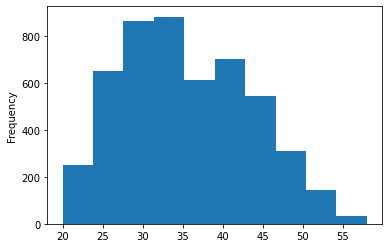

In [13]:
df.idade.plot.hist()

In [14]:
df[df.mau == 0].idade.mode()[0], df[df.mau == 1].idade.mode()[0]

(33, 26)

In [15]:
discretizer = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')
df = df.assign(idade_faixas = discretizer.fit_transform(df.idade.values.reshape(-1,1)) )
bin_counts('idade', 'idade_faixas', df.shape[0])

faixa: 2.0 qdte: 910 %total: 18.2 minimo: 31 maximo: 34
faixa: 5.0 qdte: 870 %total: 17.4 minimo: 44 maximo: 58
faixa: 4.0 qdte: 864 %total: 17.28 minimo: 39 maximo: 43
faixa: 3.0 qdte: 816 %total: 16.32 minimo: 35 maximo: 38
faixa: 1.0 qdte: 809 %total: 16.18 minimo: 27 maximo: 30
faixa: 0.0 qdte: 731 %total: 14.62 minimo: 20 maximo: 26


In [16]:
#renomeia as faixas
a = { 0 : 'de 20 a 26 anos', 
      1 : 'de 27 a 30 anos',
      2 : 'de 31 a 34 anos',
      3 : 'de 35 a 38 anos',
      4 : 'de 39 a 43 anos',
      5 : 'de 44 a 58 anos'
}
df['idade_faixas'] = df['idade_faixas'].map(a)

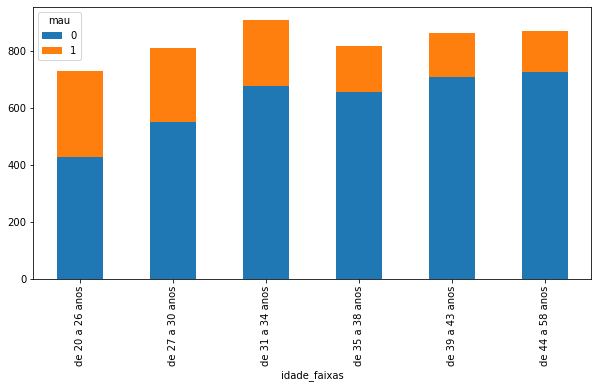

,idade_faixas,mau
0,de 20 a 26 anos,0.415869
1,de 27 a 30 anos,0.318912
2,de 31 a 34 anos,0.254945
3,de 35 a 38 anos,0.197304
4,de 39 a 43 anos,0.180556
5,de 44 a 58 anos,0.166667


In [17]:
df.groupby(['idade_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['idade_faixas', 'mau']].groupby(['idade_faixas'], as_index=False).mean()

## As faixas etárias com a maior taxa de maus é de 20 a 26 anos com 41,58% de maus

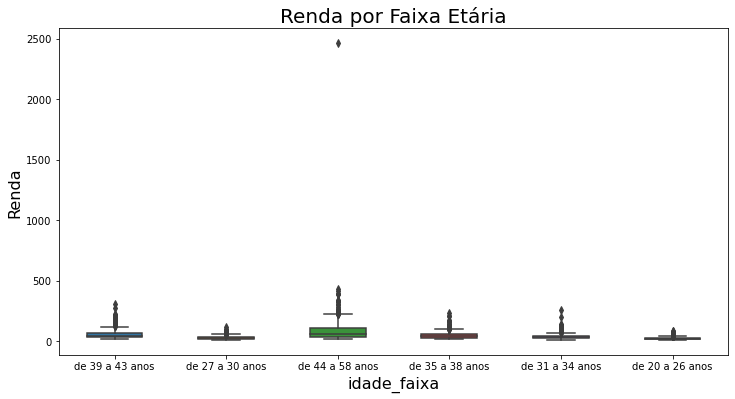

In [18]:
ax = sns.boxplot(y='renda', x='idade_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(12,6)
ax.set_title('Renda por Faixa Etária', fontsize=20)
ax.set_ylabel('Renda', fontsize=16)
ax.set_xlabel('idade_faixa', fontsize=16)
ax

### na variável de renda existe um outlier que foi verificado nas estatísticas descritivas

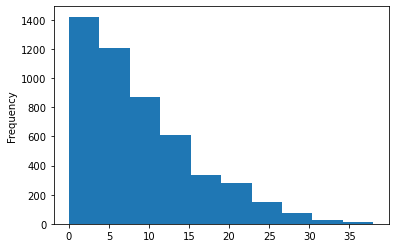

In [19]:
df.experiencia.plot.hist()

In [20]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df = df.assign(experiencia_faixas = discretizer.fit_transform(df.experiencia.values.reshape(-1,1)) )
bin_counts('experiencia', 'experiencia_faixas', df.shape[0])

faixa: 2.0 qdte: 1136 %total: 22.72 minimo: 5 maximo: 8
faixa: 3.0 qdte: 1104 %total: 22.08 minimo: 9 maximo: 14
faixa: 4.0 qdte: 1019 %total: 20.38 minimo: 15 maximo: 38
faixa: 1.0 qdte: 983 %total: 19.66 minimo: 2 maximo: 4
faixa: 0.0 qdte: 758 %total: 15.16 minimo: 0 maximo: 1


In [21]:
#renomeia as faixas
a = { 0 : 'de 0 a 01 ano', 
      1 : 'de 02 a 04 anos',
      2 : 'de 05 a 08 anos',
      3 : 'de 09 a 14 anos',
      4 : 'de 15 a 38 anos'
}
df['experiencia_faixas'] = df['experiencia_faixas'].map(a)

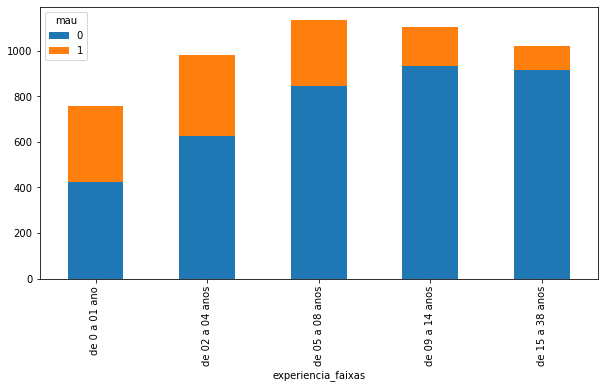

,experiencia_faixas,mau
0,de 0 a 01 ano,0.439314
1,de 02 a 04 anos,0.365209
2,de 05 a 08 anos,0.255282
3,de 09 a 14 anos,0.155797
4,de 15 a 38 anos,0.100098


In [22]:
df.groupby(['experiencia_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['experiencia_faixas', 'mau']].groupby(['experiencia_faixas'], as_index=False).mean()

### O tempo de experiencia do cliente tem comportamento semelhante a variável idade.

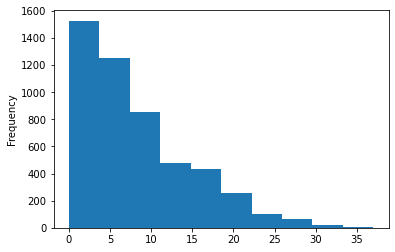

In [23]:
df.tempo_endereco.plot.hist()

In [24]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df = df.assign(endereco_faixas = discretizer.fit_transform(df.tempo_endereco.values.reshape(-1,1)) )
bin_counts('tempo_endereco', 'endereco_faixas', df.shape[0])

faixa: 3.0 qdte: 1198 %total: 23.96 minimo: 8 maximo: 13
faixa: 1.0 qdte: 1118 %total: 22.36 minimo: 2 maximo: 4
faixa: 4.0 qdte: 1022 %total: 20.44 minimo: 14 maximo: 37
faixa: 2.0 qdte: 904 %total: 18.08 minimo: 5 maximo: 7
faixa: 0.0 qdte: 758 %total: 15.16 minimo: 0 maximo: 1


In [25]:
#renomeia as faixas
a = { 0 : 'de 0 a 01 ano', 
      1 : 'de 02 a 04 anos',
      2 : 'de 05 a 07 anos',
      3 : 'de 08 a 13 anos',
      4 : 'de 14 a 37 anos'
}
df['endereco_faixas'] = df['endereco_faixas'].map(a)

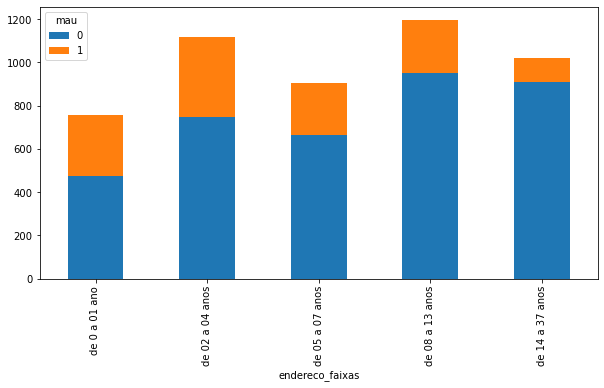

,endereco_faixas,mau
0,de 0 a 01 ano,0.374670
1,de 02 a 04 anos,0.332737
2,de 05 a 07 anos,0.266593
3,de 08 a 13 anos,0.204508
4,de 14 a 37 anos,0.111546


In [26]:
df.groupby(['endereco_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['endereco_faixas', 'mau']].groupby(['endereco_faixas'], as_index=False).mean()

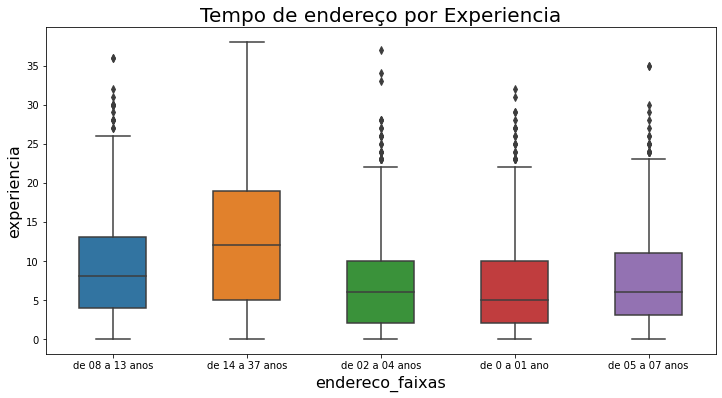

In [27]:
ax = sns.boxplot(y='experiencia', x='endereco_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(12,6)
ax.set_title('Tempo de endereço por Experiencia', fontsize=20)
ax.set_ylabel('experiencia', fontsize=16)
ax.set_xlabel('endereco_faixas', fontsize=16)
ax

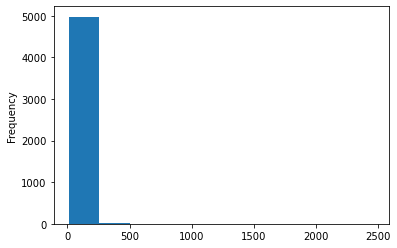

In [28]:
df.renda.plot.hist()

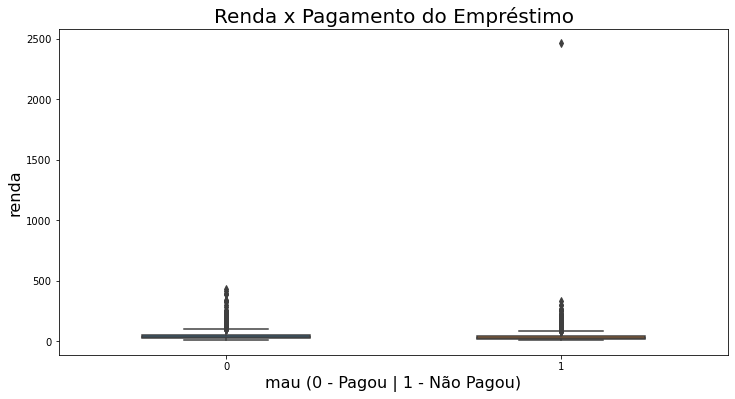

In [29]:
ax = sns.boxplot(y='renda', x='mau', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(12,6)
ax.set_title('Renda x Pagamento do Empréstimo', fontsize=20)
ax.set_ylabel('renda', fontsize=16)
ax.set_xlabel('mau (0 - Pagou | 1 - Não Pagou)', fontsize=16)
ax

### Será removido da base o outlier da variável renda

In [30]:
outlier = df.renda.max()

In [31]:
df = df[df.renda < outlier]

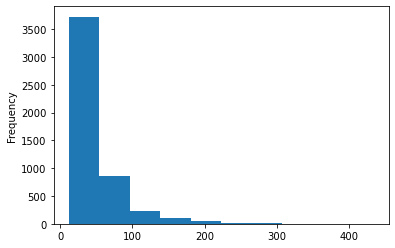

In [32]:
df.renda.plot.hist()

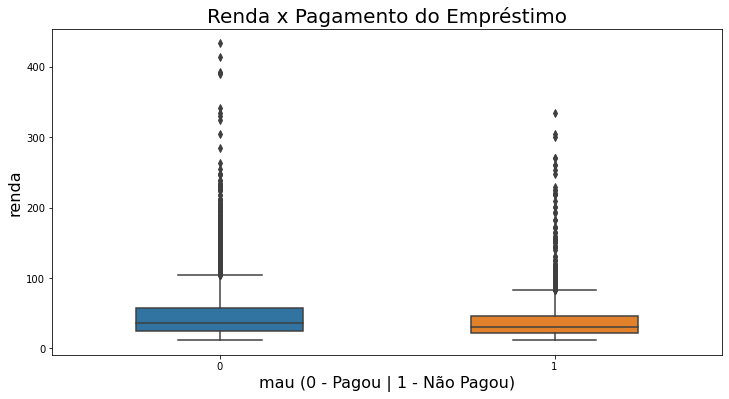

In [33]:
ax = sns.boxplot(y='renda', x='mau', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(12,6)
ax.set_title('Renda x Pagamento do Empréstimo', fontsize=20)
ax.set_ylabel('renda', fontsize=16)
ax.set_xlabel('mau (0 - Pagou | 1 - Não Pagou)', fontsize=16)
ax

In [34]:
discretizer = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='quantile')
df = df.assign(renda_faixas = discretizer.fit_transform(df.renda.values.reshape(-1,1)) )
bin_counts('renda', 'renda_faixas', df.shape[0])

faixa: 6.0 qdte: 561 %total: 11.22 minimo: 45.3 maximo: 58.1
faixa: 4.0 qdte: 560 %total: 11.2 minimo: 31.9 maximo: 37.2
faixa: 7.0 qdte: 558 %total: 11.16 minimo: 58.2 maximo: 83.5
faixa: 8.0 qdte: 556 %total: 11.12 minimo: 83.7 maximo: 433.0
faixa: 0.0 qdte: 556 %total: 11.12 minimo: 12.1 maximo: 19.9
faixa: 2.0 qdte: 556 %total: 11.12 minimo: 23.6 maximo: 27.3
faixa: 5.0 qdte: 553 %total: 11.06 minimo: 37.3 maximo: 45.2
faixa: 3.0 qdte: 552 %total: 11.04 minimo: 27.4 maximo: 31.8
faixa: 1.0 qdte: 547 %total: 10.94 minimo: 20.0 maximo: 23.5


In [35]:
#renomeia as faixas
a = { 0 : 'de 12.1 a 19.9 sal.', 
      1 : 'de 20.0 a 23.5 sal.',
      2 : 'de 23.6 a 27.3 sal.',
      3 : 'de 27.4 a 31.8 sal.',
      4 : 'de 31.9 a 37.2 sal.',
      5 : 'de 37.3 a 45.2 sal.',
      6 : 'de 45.3 a 58.1 sal.',
      7 : 'de 58.2 a 83.5 sal.',
      8 : 'de 83.7 a 433.0 sal.'
}
df['renda_faixas'] = df['renda_faixas'].map(a)

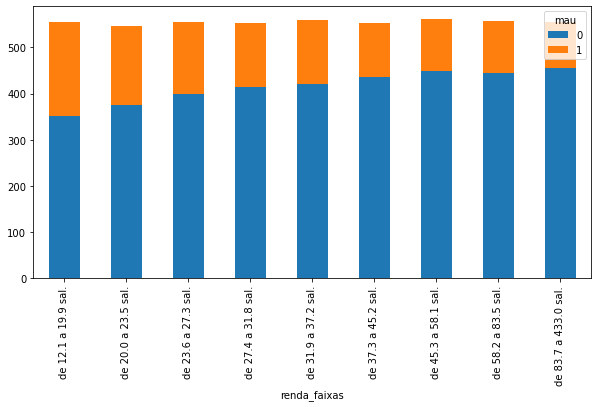

,renda_faixas,mau
0,de 12.1 a 19.9 sal.,0.368705
1,de 20.0 a 23.5 sal.,0.314442
2,de 23.6 a 27.3 sal.,0.280576
3,de 27.4 a 31.8 sal.,0.250000
4,de 31.9 a 37.2 sal.,0.250000
5,de 37.3 a 45.2 sal.,0.213382
6,de 45.3 a 58.1 sal.,0.197861
7,de 58.2 a 83.5 sal.,0.204301
8,de 83.7 a 433.0 sal.,0.181655


In [36]:
df.groupby(['renda_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['renda_faixas', 'mau']].groupby(['renda_faixas'], as_index=False).mean()

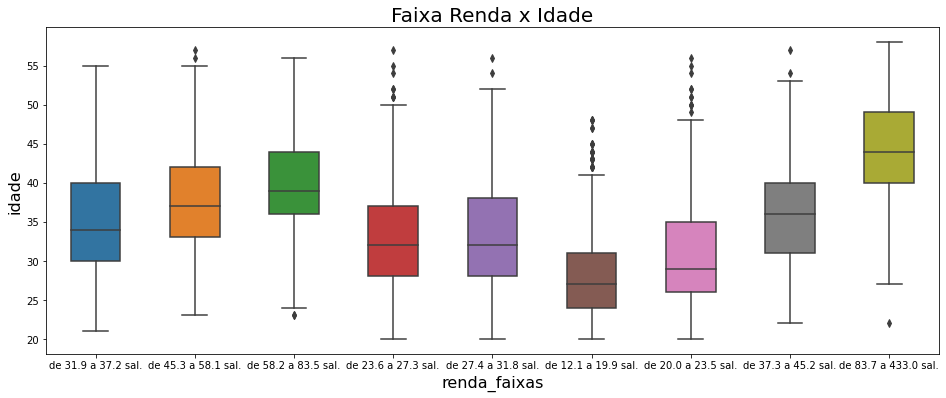

In [37]:
ax = sns.boxplot(y='idade', x='renda_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(16,6)
ax.set_title('Faixa Renda x Idade', fontsize=20)
ax.set_ylabel('idade', fontsize=16)
ax.set_xlabel('renda_faixas', fontsize=16)
ax

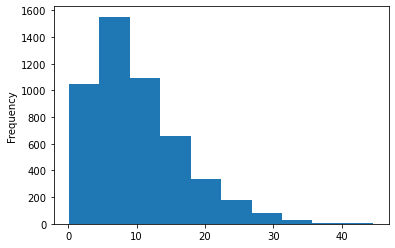

In [38]:
df.debito_renda.plot.hist()

In [39]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df = df.assign(debito_faixas = discretizer.fit_transform(df.debito_renda.values.reshape(-1,1)) )
bin_counts('debito_renda', 'debito_faixas', df.shape[0])

faixa: 4.0 qdte: 1004 %total: 20.08 minimo: 15.12 maximo: 44.62
faixa: 1.0 qdte: 1000 %total: 20.0 minimo: 4.39 maximo: 7.16
faixa: 0.0 qdte: 1000 %total: 20.0 minimo: 0.08 maximo: 4.38
faixa: 2.0 qdte: 998 %total: 19.96 minimo: 7.17 maximo: 10.35
faixa: 3.0 qdte: 997 %total: 19.94 minimo: 10.36 maximo: 15.11


In [40]:
#renomeia as faixas
a = { 0 : 'de 0.08 a 04.38', 
      1 : 'de 04.39 a 07.16',
      2 : 'de 07.17 a 10.35',
      3 : 'de 10.36 a 15.11',
      4 : 'de 15.12 a 44.62'
}
df['debito_faixas'] = df['debito_faixas'].map(a)

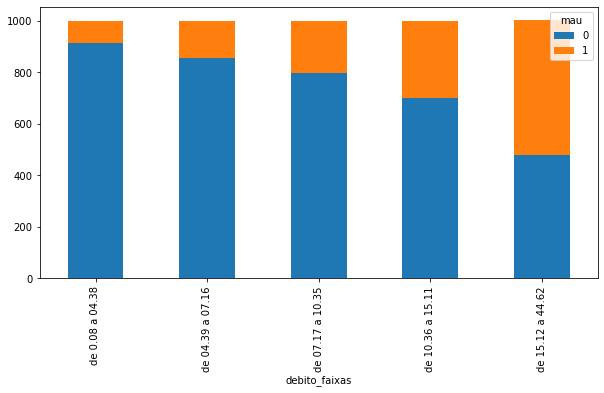

,debito_faixas,mau
0,de 0.08 a 04.38,0.088000
1,de 04.39 a 07.16,0.145000
2,de 07.17 a 10.35,0.200401
3,de 10.36 a 15.11,0.298897
4,de 15.12 a 44.62,0.521912


In [41]:
df.groupby(['debito_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['debito_faixas', 'mau']].groupby(['debito_faixas'], as_index=False).mean()

### Quanto maior o comprometimento da renda maior a taxa de maus

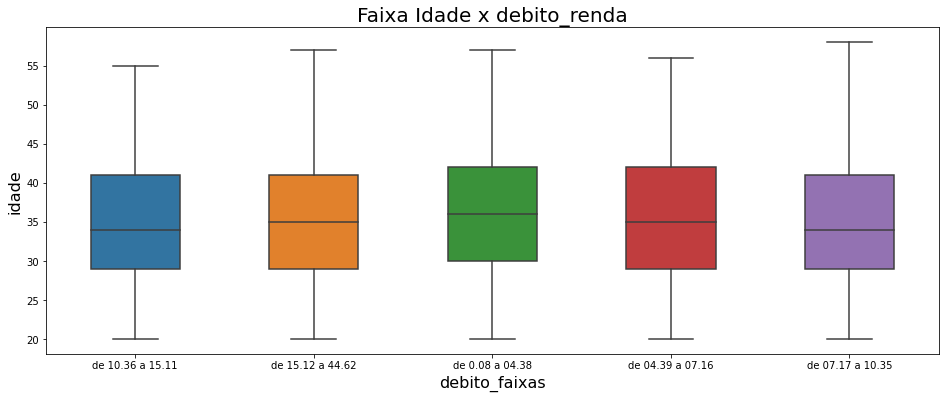

In [42]:
ax = sns.boxplot(y='idade', x='debito_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(16,6)
ax.set_title('Faixa Idade x debito_renda', fontsize=20)
ax.set_ylabel('idade', fontsize=16)
ax.set_xlabel('debito_faixas', fontsize=16)
ax

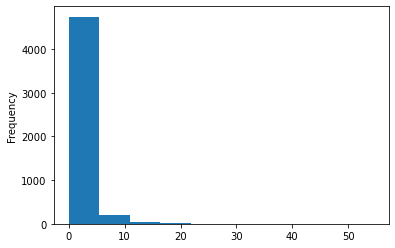

In [43]:
df.cred_deb.plot.hist()

In [44]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df = df.assign(cred_deb_faixas = discretizer.fit_transform(df.cred_deb.values.reshape(-1,1)) )
bin_counts('cred_deb', 'cred_deb_faixas', df.shape[0])

faixa: 0.0 qdte: 1000 %total: 20.0 minimo: 0.005292 maximo: 0.3208815
faixa: 4.0 qdte: 1000 %total: 20.0 minimo: 2.25595624 maximo: 54.4990416
faixa: 3.0 qdte: 1000 %total: 20.0 minimo: 1.19058342 maximo: 2.2557708
faixa: 1.0 qdte: 1000 %total: 20.0 minimo: 0.3211243 maximo: 0.6802708000000001
faixa: 2.0 qdte: 999 %total: 19.98 minimo: 0.6804184 maximo: 1.19009682


In [45]:
#renomeia as faixas
a = { 0 : 'de 0.005 a 0.320', 
      1 : 'de 0.321 a 0.680',
      2 : 'de 0.680 a 1.190',
      3 : 'de 1.190 a 2.255',
      4 : 'de 2.255 a 54.49'
}
df['cred_deb_faixas'] = df['cred_deb_faixas'].map(a)

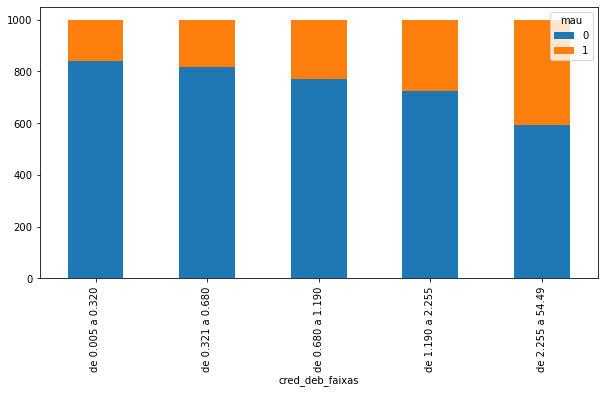

,cred_deb_faixas,mau
0,de 0.005 a 0.320,0.159000
1,de 0.321 a 0.680,0.182000
2,de 0.680 a 1.190,0.228228
3,de 1.190 a 2.255,0.277000
4,de 2.255 a 54.49,0.409000


In [46]:
df.groupby(['cred_deb_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['cred_deb_faixas', 'mau']].groupby(['cred_deb_faixas'], as_index=False).mean()

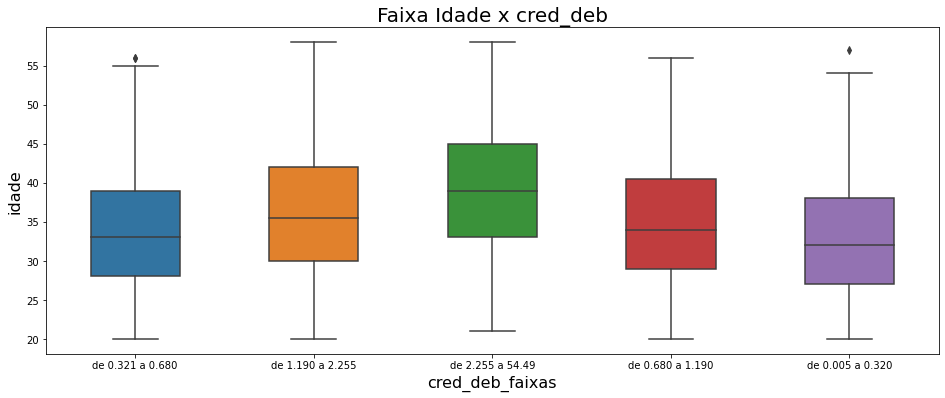

In [47]:
ax = sns.boxplot(y='idade', x='cred_deb_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(16,6)
ax.set_title('Faixa Idade x cred_deb', fontsize=20)
ax.set_ylabel('idade', fontsize=16)
ax.set_xlabel('cred_deb_faixas', fontsize=16)
ax

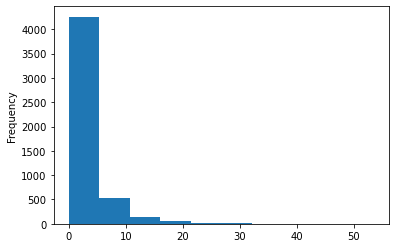

In [48]:
df.outros_debitos.plot.hist()

In [49]:
discretizer = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='quantile')
df = df.assign(outros_debitos_faixas = discretizer.fit_transform(df.outros_debitos.values.reshape(-1,1)) )
bin_counts('outros_debitos', 'outros_debitos_faixas', df.shape[0])

faixa: 6.0 qdte: 715 %total: 14.3 minimo: 5.4916785 maximo: 53.40152064
faixa: 1.0 qdte: 714 %total: 14.28 minimo: 0.6673209 maximo: 1.10957025
faixa: 3.0 qdte: 714 %total: 14.28 minimo: 1.63697616 maximo: 2.35635092
faixa: 2.0 qdte: 714 %total: 14.28 minimo: 1.10978895 maximo: 1.63629725
faixa: 0.0 qdte: 714 %total: 14.28 minimo: 0.00937296 maximo: 0.6672876
faixa: 4.0 qdte: 714 %total: 14.28 minimo: 2.35717076 maximo: 3.42961878
faixa: 5.0 qdte: 714 %total: 14.28 minimo: 3.4321248 maximo: 5.48621348


In [50]:
#renomeia as faixas
a = { 0 : 'de 0.009 a 0.667', 
      1 : 'de 0.667 a 1.109',
      2 : 'de 1.109 a 1.636',
      3 : 'de 1.636 a 2.356',
      4 : 'de 2.357 a 3.429',
      5 : 'de 3.432 a 5.486',
      6 : 'de 5.491 a 53.401'
}
df['outros_debitos_faixas'] = df['outros_debitos_faixas'].map(a)

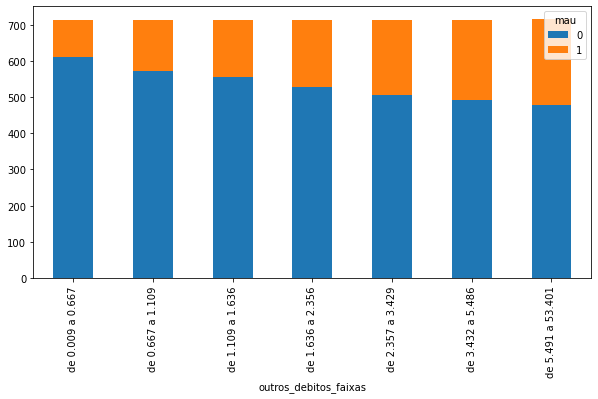

,outros_debitos_faixas,mau
0,de 0.009 a 0.667,0.145658
1,de 0.667 a 1.109,0.198880
2,de 1.109 a 1.636,0.221289
3,de 1.636 a 2.356,0.259104
4,de 2.357 a 3.429,0.291317
5,de 3.432 a 5.486,0.309524
6,de 5.491 a 53.401,0.331469


In [51]:
df.groupby(['outros_debitos_faixas','mau']).size().unstack().plot(kind='bar',stacked=True, figsize=(10, 5))
plt.show()
df[['outros_debitos_faixas', 'mau']].groupby(['outros_debitos_faixas'], as_index=False).mean()

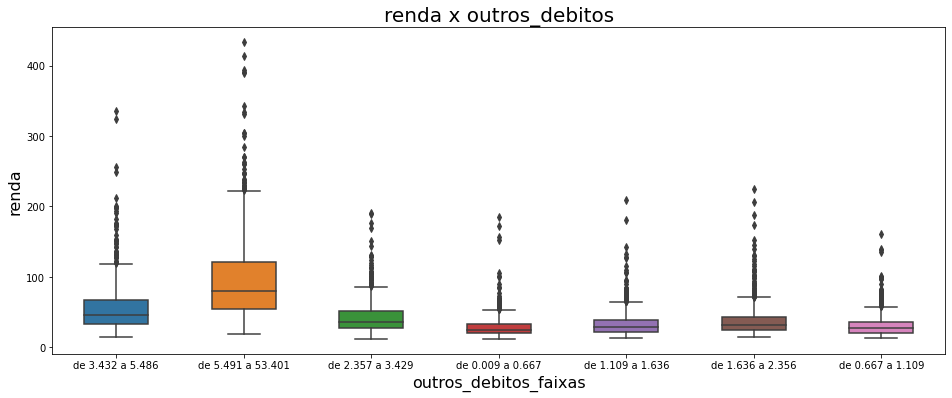

In [52]:
ax = sns.boxplot(y='renda', x='outros_debitos_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(16,6)
ax.set_title('renda x outros_debitos', fontsize=20)
ax.set_ylabel('renda', fontsize=16)
ax.set_xlabel('outros_debitos_faixas', fontsize=16)
ax

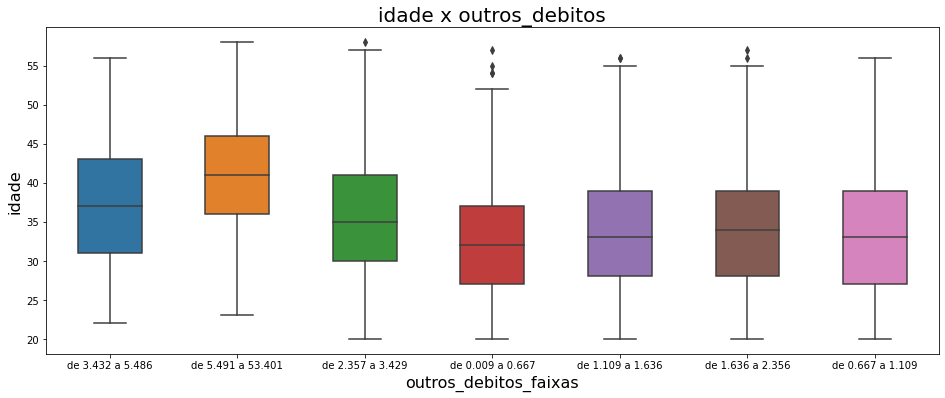

In [53]:
ax = sns.boxplot(y='idade', x='outros_debitos_faixas', data=df, orient='v', width=0.5)
ax.figure.set_size_inches(16,6)
ax.set_title('idade x outros_debitos', fontsize=20)
ax.set_ylabel('idade', fontsize=16)
ax.set_xlabel('outros_debitos_faixas', fontsize=16)
ax

<br>

## Correlação entre as variáveis da base de dados

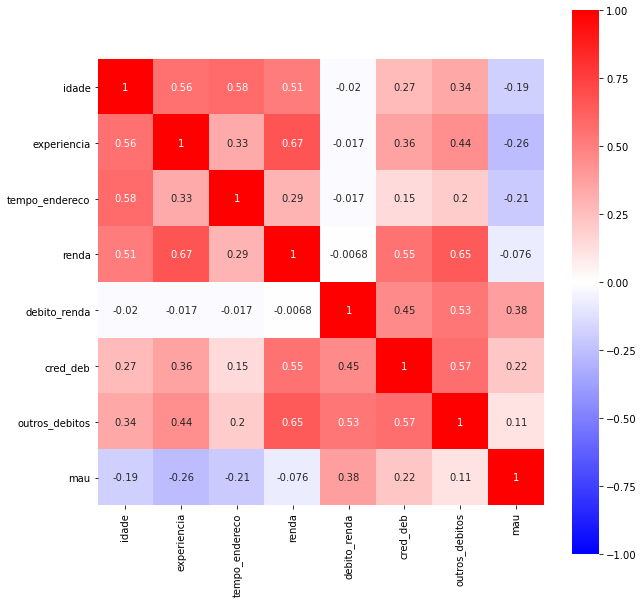

In [54]:
matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(matrix, vmax=1, vmin=-1, cmap="bwr", square=True, annot=True)
plt.show()

<b>As variáveis da base com maior correlação são: <br>
renda x experiencia com 0,67<br>
renda x outros_debitos com 0,65</b>

### Variáveis Categóricas
Para as variáveis categóricas não é possivel aplicar o teste de correlação de Pearson/Spearman.<br>
Será aplicado o teste do qui quadrado, que utiliza uma tabela de contigencia para a combinação das variáveis.<br> 
A hipótese nula é de que as variáveis são independentes.

In [55]:
variaveis = ['idade_faixas',
             'experiencia_faixas', 'endereco_faixas', 'renda_faixas',
             'debito_faixas', 'cred_deb_faixas', 'outros_debitos_faixas']
combinacao = list(combinations(variaveis, 2))

In [56]:
conf = 0.95
for i in combinacao:
    con= pd.crosstab(df[i[0]], df[i[1]])
    c, p, dof, expected = chi2_contingency(con)
    t = 'Aceita' if p < conf else 'Rejeita'
    print('%s H0 para o Chi2 com p %s para as variaveis %s e %s.' %(t, p, i[0],i[1]))

Aceita H0 para o Chi2 com p 0.0 para as variaveis idade_faixas e experiencia_faixas.
Aceita H0 para o Chi2 com p 0.0 para as variaveis idade_faixas e endereco_faixas.
Aceita H0 para o Chi2 com p 0.0 para as variaveis idade_faixas e renda_faixas.
Aceita H0 para o Chi2 com p 0.31695215383093045 para as variaveis idade_faixas e debito_faixas.
Aceita H0 para o Chi2 com p 9.201280714951222e-66 para as variaveis idade_faixas e cred_deb_faixas.
Aceita H0 para o Chi2 com p 1.3687661990473853e-101 para as variaveis idade_faixas e outros_debitos_faixas.
Aceita H0 para o Chi2 com p 1.6648604746752801e-90 para as variaveis experiencia_faixas e endereco_faixas.
Aceita H0 para o Chi2 com p 0.0 para as variaveis experiencia_faixas e renda_faixas.
Aceita H0 para o Chi2 com p 0.4889591836920688 para as variaveis experiencia_faixas e debito_faixas.
Aceita H0 para o Chi2 com p 1.0083787907788913e-107 para as variaveis experiencia_faixas e cred_deb_faixas.
Aceita H0 para o Chi2 com p 4.0969122883301553e-1

In [57]:
variaveis.append('mau')

In [58]:
data = df[variaveis]

In [59]:
def woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [60]:
resumo = []
for col in data.columns:
    if col == 'mau': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        dt, iv = woe_iv(data, col, 'mau')
        resumo.append([col, iv])
        print(dt)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: idade_faixas
             Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
5  de 20 a 26 anos  731   427  304    0.114049   0.242231 -0.753263  0.096555
1  de 27 a 30 anos  809   551  258    0.147169   0.205578 -0.334244  0.019523
4  de 31 a 34 anos  910   678  232    0.181090   0.184861 -0.020609  0.000078
3  de 35 a 38 anos  816   655  161    0.174947   0.128287  0.310212  0.014474
0  de 39 a 43 anos  864   708  156    0.189103   0.124303  0.419569  0.027188
2  de 44 a 58 anos  869   725  144    0.193643   0.114741  0.523339  0.041293
IV score: 0.20


WoE and IV for column: experiencia_faixas
             Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
3    de 0 a 01 ano   758   425  333    0.113515   0.265339 -0.849072  0.128909
4  de 02 a 04 anos   983   624  359    0.166667   0.286056 -0.540191  0.064493
2  de 05 a 08 anos  1136   846  290    0.225962   0.231076 -0.022381  0.000114
1  de 09 a 14 anos  1104   932  172    0.24

In [61]:
for i in resumo:
    if i[1] < 0.02:
        t = 'Ruim'
    elif i[1] < 0.1:
        t = 'Fraco'
    elif i[1] < 0.3:
        t = 'Médio'
    elif i[1] < 0.5:
        t = 'Forte'
    else:
        t = 'Ótimo'
    
    print('Variável %s com iv: %s (%s)' %(i[0],round(i[1],2), t))

Variável idade_faixas com iv: 0.2 (Médio)
Variável experiencia_faixas com iv: 0.44 (Forte)
Variável endereco_faixas com iv: 0.26 (Médio)
Variável renda_faixas com iv: 0.09 (Fraco)
Variável debito_faixas com iv: 0.66 (Ótimo)
Variável cred_deb_faixas com iv: 0.21 (Médio)
Variável outros_debitos_faixas com iv: 0.11 (Médio)


In [62]:
x = data
y = data['mau']
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size=0.30, stratify=y, random_state=42)

In [63]:
base = pd.get_dummies(treino_x)
teste = pd.get_dummies(teste_x)

In [64]:
y = base['mau']
x = base.drop(['mau'], axis=1)
teste_y = teste['mau']
teste_x = teste.drop(['mau'], axis=1)

In [65]:
rl = f_regression(x,y)
p = rl[1]

In [66]:
alfa = 0.05
lista = []
for i in range(len(p)):
    if(p[i] < alfa):
        lista.append(x.columns[i])
        print('Variável %s com p-valor: %s' %(x.columns[i],round(p[i],2)))

Variável idade_faixas_de 20 a 26 anos com p-valor: 0.0
Variável idade_faixas_de 27 a 30 anos com p-valor: 0.0
Variável idade_faixas_de 35 a 38 anos com p-valor: 0.0
Variável idade_faixas_de 39 a 43 anos com p-valor: 0.0
Variável idade_faixas_de 44 a 58 anos com p-valor: 0.0
Variável experiencia_faixas_de 0 a 01 ano com p-valor: 0.0
Variável experiencia_faixas_de 02 a 04 anos com p-valor: 0.0
Variável experiencia_faixas_de 09 a 14 anos com p-valor: 0.0
Variável experiencia_faixas_de 15 a 38 anos com p-valor: 0.0
Variável endereco_faixas_de 0 a 01 ano com p-valor: 0.0
Variável endereco_faixas_de 02 a 04 anos com p-valor: 0.0
Variável endereco_faixas_de 08 a 13 anos com p-valor: 0.0
Variável endereco_faixas_de 14 a 37 anos com p-valor: 0.0
Variável renda_faixas_de 12.1 a 19.9 sal. com p-valor: 0.0
Variável renda_faixas_de 20.0 a 23.5 sal. com p-valor: 0.0
Variável renda_faixas_de 37.3 a 45.2 sal. com p-valor: 0.02
Variável renda_faixas_de 45.3 a 58.1 sal. com p-valor: 0.03
Variável renda_

Listagem das variaveis com p-valor < 0,05, significa que alterações nas variáveis preditoras estão relacionadas com a variável resposta.

In [67]:
x = x[lista]
teste_x = teste_x[lista]

In [68]:
modelo = LogisticRegression(max_iter=100, C=0.01, penalty='l2', solver='lbfgs', class_weight=None)
modelo.fit(x, y) 

LogisticRegression(C=0.01)

In [69]:
prob_previsao = modelo.predict_proba(teste_x)[:,1]

AUC : 0.807878


,fpr,tpr,1-fpr,tf,thresholds
296,0.258237,0.740053,0.741763,-0.00171,0.269578


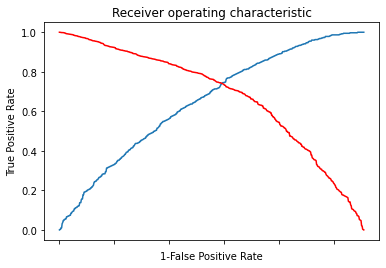

In [70]:
fpr, tpr, thresholds =roc_curve(teste_y, prob_previsao)
print("AUC : %f" % auc(fpr, tpr))

i = np.arange(len(tpr)) 
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})


fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])
roc.iloc[(roc.tf-0).abs().argsort()[:1]]


In [71]:
dataset = pd.get_dummies(data)

In [72]:
y = dataset['mau']
x = dataset.drop(columns = 'mau')
modelo = LogisticRegression(max_iter=100, C=0.01, penalty='l2', solver='lbfgs', class_weight=None)
modelo.fit(x, y) 

LogisticRegression(C=0.01)

In [73]:
scores = modelo.predict_proba(x)[:,1]

In [74]:
df['score'] = scores

In [75]:
def calc_mau(x: float) -> int:
    th = 0.269759
    if x > th:
        return 1
    else:
        return 0

df = df.assign(default = df.score.apply(calc_mau))
df.head()

,idade,experiencia,tempo_endereco,renda,debito_renda,cred_deb,outros_debitos,mau,idade_faixas,experiencia_faixas,endereco_faixas,renda_faixas,debito_faixas,cred_deb_faixas,outros_debitos_faixas,score,default
0,41,17,12,35.9,11.90,0.504108,3.767992,0,de 39 a 43 anos,de 15 a 38 anos,de 08 a 13 anos,de 31.9 a 37.2 sal.,de 10.36 a 15.11,de 0.321 a 0.680,de 3.432 a 5.486,0.118034,0
1,30,13,8,46.7,17.88,1.352694,6.997266,0,de 27 a 30 anos,de 09 a 14 anos,de 08 a 13 anos,de 45.3 a 58.1 sal.,de 15.12 a 44.62,de 1.190 a 2.255,de 5.491 a 53.401,0.323686,1
2,40,15,14,61.8,10.64,3.438997,3.136523,0,de 39 a 43 anos,de 15 a 38 anos,de 14 a 37 anos,de 58.2 a 83.5 sal.,de 10.36 a 15.11,de 2.255 a 54.49,de 2.357 a 3.429,0.162317,0
3,41,15,14,72.0,29.67,4.165668,17.196732,0,de 39 a 43 anos,de 15 a 38 anos,de 14 a 37 anos,de 58.2 a 83.5 sal.,de 15.12 a 44.62,de 2.255 a 54.49,de 5.491 a 53.401,0.282562,1
4,57,7,37,25.6,15.86,1.498199,2.561961,0,de 44 a 58 anos,de 05 a 08 anos,de 14 a 37 anos,de 23.6 a 27.3 sal.,de 15.12 a 44.62,de 1.190 a 2.255,de 2.357 a 3.429,0.280902,1


In [76]:
pred_y = df['default']

AUC : 0.816381


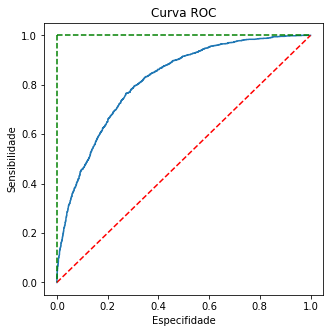

In [77]:
tfp, tvp, thresholds = roc_curve(y, scores)
print("AUC : %f" % roc_auc_score(y, scores))

plt.subplots(1, figsize=(5,5))
plt.title('Curva ROC')
plt.plot(tfp,tvp)
plt.xlabel('Especifidade')
plt.ylabel('Sensibilidade')
plt.plot([0, 1], ls="--", c = 'red') #plotando linha guia pontilhada vermelha: MODELO ALEATÓRIO
plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha guia pontilhada verde: MODELO PERFEITO
plt.show()

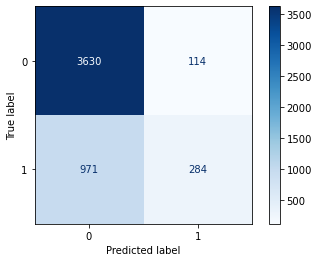

In [78]:
matriz_confusao = plot_confusion_matrix(modelo, x, y, cmap='Blues')
matriz_confusao 

In [79]:
print(classification_report(y, pred_y))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      3744
           1       0.49      0.74      0.59      1255

    accuracy                           0.74      4999
   macro avg       0.69      0.74      0.70      4999
weighted avg       0.79      0.74      0.76      4999



In [80]:
df['good'] = 1 - df.score

# quebra em faixas
df['bucket'] = pd.qcut(df.score, 10)

 # agrupa pelas faixas
grouped = df.groupby('bucket', as_index = False)

 # tabela com a contabilizacao
agg1 = grouped.min().score
agg1 = pd.DataFrame(grouped.min().score, columns = ['min_scr'])
agg1['min_scr'] = grouped.min().score
agg1['max_scr'] = grouped.max().score
agg1['bads'] = grouped.sum().score
agg1['goods'] = grouped.sum().good
agg1['total'] = agg1.bads + agg1.goods

# calculos intervalares
agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
agg2['good_rate'] = (agg2.goods / agg2.total).apply('{0:.2%}'.format)
agg2['bad_cum'] = ((agg2.bads / df.score.sum()).cumsum()).apply('{0:.2%}'.format)
agg2['good_cum'] = ((agg2.goods / df.good.sum()).cumsum()).apply('{0:.2%}'.format)
agg2['bad_total'] = df.score.sum()
agg2['good_total'] = df.good.sum()

# calculo do ks
agg2['ks'] = abs(np.round(((agg2.bads / df.score.sum()).cumsum() - (agg2.goods / df.good.sum()).cumsum()), 4) * 100)

# marca o maior ks
flag = lambda x: '<----' if x == agg2.ks.max() else ''
agg2['max_ks'] = agg2.ks.apply(flag)

pd.set_option("display.max_columns", None)
agg2

,min_scr,max_scr,bads,goods,total,odds,bad_rate,good_rate,bad_cum,good_cum,bad_total,good_total,ks,max_ks
0,0.036064,0.085981,33.610366,466.389634,500.0,13.88,6.72%,93.28%,2.68%,12.46%,1254.995274,3744.004726,9.78,
1,0.086199,0.116261,50.483752,449.516248,500.0,8.90,10.10%,89.90%,6.70%,24.46%,1254.995274,3744.004726,17.76,
2,0.116437,0.146502,65.783404,434.216596,500.0,6.60,13.16%,86.84%,11.94%,36.06%,1254.995274,3744.004726,24.12,
3,0.146523,0.178083,81.510017,418.489983,500.0,5.13,16.30%,83.70%,18.44%,47.24%,1254.995274,3744.004726,28.80,
4,0.178159,0.220424,99.275757,401.724243,501.0,4.05,19.82%,80.18%,26.35%,57.97%,1254.995274,3744.004726,31.62,
5,0.220474,0.260965,119.718942,378.281058,498.0,3.16,24.04%,75.96%,35.89%,68.07%,1254.995274,3744.004726,32.18,<----
6,0.261016,0.304585,140.832083,359.167917,500.0,2.55,28.17%,71.83%,47.11%,77.67%,1254.995274,3744.004726,30.56,
7,0.304689,0.371728,168.281227,331.718773,500.0,1.97,33.66%,66.34%,60.52%,86.53%,1254.995274,3744.004726,26.01,
8,0.371956,0.473406,209.698738,290.301262,500.0,1.38,41.94%,58.06%,77.23%,94.28%,1254.995274,3744.004726,17.05,
9,0.473569,0.777650,285.800989,214.199011,500.0,0.75,57.16%,42.84%,100.00%,100.00%,1254.995274,3744.004726,0.00,


In [81]:
df['good'] = 1 - df.score

# quebra em faixas
df['bucket'] = pd.qcut(df.score, 5)

 # agrupa pelas faixas
grouped = df.groupby('bucket', as_index = False)

 # tabela com a contabilizacao
agg1 = grouped.min().score
agg1 = pd.DataFrame(grouped.min().score, columns = ['min_scr'])
agg1['min_scr'] = grouped.min().score
agg1['max_scr'] = grouped.max().score
agg1['bads'] = grouped.sum().score
agg1['goods'] = grouped.sum().good
agg1['total'] = agg1.bads + agg1.goods

# calculos intervalares
agg2 = (agg1.sort_values(by = 'min_scr')).reset_index(drop = True)
agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
agg2['good_rate'] = (agg2.goods / agg2.total).apply('{0:.2%}'.format)
agg2['bad_cum'] = ((agg2.bads / df.score.sum()).cumsum()).apply('{0:.2%}'.format)
agg2['good_cum'] = ((agg2.goods / df.good.sum()).cumsum()).apply('{0:.2%}'.format)
agg2['bad_total'] = df.score.sum()
agg2['good_total'] = df.good.sum()

# calculo do ks
agg2['ks'] = abs(np.round(((agg2.bads / df.score.sum()).cumsum() - (agg2.goods / df.good.sum()).cumsum()), 4) * 100)

# marca o maior ks
flag = lambda x: '<----' if x == agg2.ks.max() else ''
agg2['max_ks'] = agg2.ks.apply(flag)

pd.set_option("display.max_columns", None)
agg2

,min_scr,max_scr,bads,goods,total,odds,bad_rate,good_rate,bad_cum,good_cum,bad_total,good_total,ks,max_ks
0,0.036064,0.116261,84.094118,915.905882,1000.0,10.89,8.41%,91.59%,6.70%,24.46%,1254.995274,3744.004726,17.76,
1,0.116437,0.178083,147.293420,852.706580,1000.0,5.79,14.73%,85.27%,18.44%,47.24%,1254.995274,3744.004726,28.80,
2,0.178159,0.260965,218.994700,780.005300,999.0,3.56,21.92%,78.08%,35.89%,68.07%,1254.995274,3744.004726,32.18,<----
3,0.261016,0.371728,309.113310,690.886690,1000.0,2.24,30.91%,69.09%,60.52%,86.53%,1254.995274,3744.004726,26.01,
4,0.371956,0.777650,495.499726,504.500274,1000.0,1.02,49.55%,50.45%,100.00%,100.00%,1254.995274,3744.004726,0.00,
